## reAct Agents Architecture




In [17]:
from dotenv import load_dotenv
load_dotenv()  # take environment variables from .env file

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["LANGSMITH_ENDPOINT"] = os.getenv("LANGSMITH_ENDPOINT")
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = os.getenv("LANGSMITH_PROJECT")

In [2]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import  WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults

api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=5, doc_content_chars_max=5000)

arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)

api_wrapper_wikipedia = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=5000)
wikipedia = WikipediaQueryRun(api_wrapper=api_wrapper_wikipedia)

tavily = TavilySearchResults()

C:\Users\k\AppData\Local\Temp\ipykernel_17384\2046110120.py:12: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [3]:
def multiply(a:int , b:int):
    """Multiplies two numbers"""
    return a*b

def add(a:int , b:int):
    """Adds two numbers"""
    return a+b

In [4]:
tools = [arxiv, wikipedia, tavily, multiply, add]

In [5]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [6]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import  ToolNode, tools_condition

In [7]:
## State Schema

class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

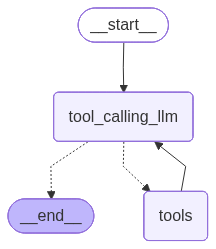

In [8]:
## node defination
def tool_calling_llm(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}
    
builder = StateGraph(State)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm",tools_condition)

builder.add_edge("tools", "tool_calling_llm")

builder.add_edge("tool_calling_llm", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
messages= graph.invoke({"messages":"Provide me latest AI news and asl who invented AI first. and also do 5 plus 5 and multiple the result with 10"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me latest AI news and asl who invented AI first. and also do 5 plus 5 and multiple the result with 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (b2hz8qcn4)
 Call ID: b2hz8qcn4
  Args:
    query: latest AI news
  wikipedia (se3cpyybm)
 Call ID: se3cpyybm
  Args:
    query: history of artificial intelligence
  add (65938nr1t)
 Call ID: 65938nr1t
  Args:
    a: 5
    b: 5
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest News | Insights Powering AI-Driven Business ...", "url": "https://www.artificialintelligence-news.com/", "content": "AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emerging tech worldwide.", "score": 0.7728226}, {"title": "AI News | Latest Headl

## Agent Memory
# MemorySaver

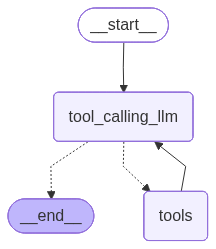

In [11]:
from langgraph.checkpoint.memory import MemorySaver

graph_with_memory = builder.compile(checkpointer=MemorySaver())

display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [15]:

config = {"configurable": {"thread_id": "test_thread_id"}}
messages= graph_with_memory.invoke({"messages":"Provide me latest AI news and asl who invented AI first. and also do 5 plus 5 and multiple the result with 10"}, config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me latest AI news and asl who invented AI first. and also do 5 plus 5 and multiple the result with 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (sb9f81s2p)
 Call ID: sb9f81s2p
  Args:
    query: latest AI news
  wikipedia (kz8y8z7mq)
 Call ID: kz8y8z7mq
  Args:
    query: history of artificial intelligence
  add (eevxb8z6z)
 Call ID: eevxb8z6z
  Args:
    a: 5
    b: 5
  multiply (qwpnb09kg)
 Call ID: qwpnb09kg
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "url": "https://www.artificialintelligence-news.com/", "content": "AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emergin

In [16]:
messages= graph_with_memory.invoke({"messages":"add 100 in the result of previous query result"},config=config)

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me latest AI news and asl who invented AI first. and also do 5 plus 5 and multiple the result with 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (sb9f81s2p)
 Call ID: sb9f81s2p
  Args:
    query: latest AI news
  wikipedia (kz8y8z7mq)
 Call ID: kz8y8z7mq
  Args:
    query: history of artificial intelligence
  add (eevxb8z6z)
 Call ID: eevxb8z6z
  Args:
    a: 5
    b: 5
  multiply (qwpnb09kg)
 Call ID: qwpnb09kg
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | Latest News | Insights Powering AI-Driven Business Growth", "url": "https://www.artificialintelligence-news.com/", "content": "AI News delivers the latest updates in artificial intelligence, machine learning, deep learning, enterprise AI, and emergin